# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
warnings.filterwarnings("ignore")


In [17]:
data = pd.read_csv('/datasets/autos.csv')
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
data.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

In [4]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
# Удаление не нужных для обучения столбцов
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

# Удаение сторк где есть нулевые значения
data = data.loc[data.ne(0).all(axis=1)]

# Замена nan на ink (i do't know)
data['VehicleType'] = data['VehicleType'].fillna('idk')
data['Gearbox'] = data['Gearbox'].fillna('idk')
data['Model'] = data['Model'].fillna('idk')
data['FuelType'] = data['FuelType'].fillna('idk')
data['NotRepaired'] = data['NotRepaired'].fillna('idk')

# Удаление столбцов с аномальными значениями 
#(в 1886 появилась первая машина, самая мощьная машина 1300, а самая маломощьная 5)
# Дешевле 100евро машину врядли купишь
data = data.query(' RegistrationYear <= 2016 and RegistrationYear >= 1886')
data = data.query(' Price >= 100')
data = data.query(' Power >= 5 and Power <= 1300')

# создание нового списка для кодирования
data_rep = data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']]

# кодирование
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data_rep),
                            columns=data_rep.columns)


In [6]:
data = data.reset_index(drop=True)

удалил нулевые значения

In [7]:
data_ordinal[['Price', 'RegistrationYear', 'Power', 'Kilometer']] = data[['Price', 'RegistrationYear', 'Power', 'Kilometer']]

*Замена занчения из главного датафрейма на кодированые*

In [8]:
data = data_ordinal
data

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,Price,RegistrationYear,Power,Kilometer
0,2.0,2.0,121.0,2.0,1.0,2.0,18300,2011,190,125000
1,7.0,0.0,117.0,2.0,14.0,0.0,9800,2004,163,125000
2,6.0,2.0,116.0,7.0,38.0,1.0,1500,2001,75,150000
3,6.0,2.0,101.0,2.0,31.0,1.0,3600,2008,69,90000
4,5.0,2.0,11.0,7.0,2.0,2.0,650,1995,102,150000
...,...,...,...,...,...,...,...,...,...,...
295437,3.0,0.0,4.0,4.0,0.0,1.0,5250,2016,150,150000
295438,5.0,2.0,141.0,7.0,30.0,2.0,3200,2004,225,150000
295439,1.0,0.0,106.0,7.0,32.0,1.0,1199,2000,101,125000
295440,0.0,2.0,224.0,2.0,38.0,1.0,9200,1996,102,150000


**Данные я подготовил удалив не нужные столбцы, удалил столбцы с значениям 0. Заменил значения nan в столбцах 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired' на IDK. Так же выполнил кадирование**

# 2. Обучение моделей

In [9]:
data_new = data.astype(int)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295442 entries, 0 to 295441
Data columns (total 10 columns):
VehicleType         295442 non-null float64
Gearbox             295442 non-null float64
Model               295442 non-null float64
FuelType            295442 non-null float64
Brand               295442 non-null float64
NotRepaired         295442 non-null float64
Price               295442 non-null int64
RegistrationYear    295442 non-null int64
Power               295442 non-null int64
Kilometer           295442 non-null int64
dtypes: float64(6), int64(4)
memory usage: 22.5 MB


In [10]:
train, valid, test = np.split(data_new.sample(frac=1, random_state=12345),
                                 [int(.6*len(data_new)), int(.8*len(data_new))])

# переменные для признаков и целевого признака
features_train = train.drop(['Price'], axis=1)
target_train = train['Price']

features_valid = valid.drop(['Price'], axis=1)
target_valid = valid['Price'] 

features_test = test.drop(['Price'], axis=1)
target_test = test['Price']
print(train.shape)
print(valid.shape)
print(test.shape)

(177265, 10)
(59088, 10)
(59089, 10)


In [11]:
%%time
model = LinearRegression()
model.fit(features_train, target_train) 
predictions_valid = model.predict(features_valid)
mse = mean_squared_error(target_valid, predictions_valid)
print("MSE:", mse)
rmse = mse ** 0.5 
print("RMSE:", rmse)


MSE: 9800778.366969856
RMSE: 3130.6194861352687
CPU times: user 44.3 ms, sys: 30.7 ms, total: 75 ms
Wall time: 46.8 ms


In [12]:
%%time

model1 = CatBoostRegressor(iterations=200, learning_rate=0.5, depth = 10)
# Fit model
model1.fit(features_train, target_train, verbose=10) 
predictions_valid1 = model1.predict(features_valid)
mse1 = mean_squared_error(target_valid, predictions_valid1)
print("MSE:", mse1)
rmse1 = mse1 ** 0.5 
print("RMSE:", rmse1)

0:	learn: 3090.6846694	total: 237ms	remaining: 47.1s
10:	learn: 1754.0479835	total: 2.43s	remaining: 41.8s
20:	learn: 1658.4791985	total: 4.72s	remaining: 40.3s
30:	learn: 1601.6258615	total: 7.02s	remaining: 38.3s
40:	learn: 1556.1630225	total: 9.31s	remaining: 36.1s
50:	learn: 1519.6964562	total: 11.6s	remaining: 33.9s
60:	learn: 1496.3406649	total: 13.9s	remaining: 31.7s
70:	learn: 1470.3642301	total: 16.2s	remaining: 29.4s
80:	learn: 1447.5532567	total: 18.5s	remaining: 27.1s
90:	learn: 1427.0661759	total: 20.8s	remaining: 24.9s
100:	learn: 1412.6116515	total: 23.1s	remaining: 22.6s
110:	learn: 1400.7755346	total: 25.4s	remaining: 20.3s
120:	learn: 1386.6743424	total: 27.6s	remaining: 18s
130:	learn: 1376.8836607	total: 29.9s	remaining: 15.7s
140:	learn: 1364.2201813	total: 32.1s	remaining: 13.5s
150:	learn: 1353.0205480	total: 34.5s	remaining: 11.2s
160:	learn: 1340.5191579	total: 36.9s	remaining: 8.94s
170:	learn: 1331.8891619	total: 39.2s	remaining: 6.65s
180:	learn: 1323.515607

In [14]:
%%time
train=lgb.Dataset(features_train, label=target_train)

params={}
params['learning_rate']=1
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='regression'#regression task
params['n_estimators']=200
params['max_depth']= 10

model2=lgb.train(params,train,  10)

predictions_valid2=model2.predict(features_valid)

mse2 = mean_squared_error(target_valid, predictions_valid2)
print("MSE:", mse2)
rmse2 = mse2 ** 0.5 
print("RMSE:", rmse2)



MSE: 2748948.3696521693
RMSE: 1657.9952863781516
CPU times: user 11.6 s, sys: 38.8 ms, total: 11.7 s
Wall time: 11.8 s


In [14]:
%%time
model3 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 100)

model3.fit(features_train, target_train)

predictions_valid3 = model3.predict(features_valid)

mse3 = mean_squared_error(target_valid, predictions_valid3)
print("MSE:", mse3)
rmse3 = mse3 ** 0.5 
print("RMSE:", rmse3)

[10:25:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 2923632.7679058257
RMSE: 1709.8633769707526
CPU times: user 9.11 s, sys: 0 ns, total: 9.11 s
Wall time: 9.79 s


**Самой быстро обучающейся моделью является  LightGBM. Так же у этой модели получается довольно хорошая метрика качества**

# 3. Анализ моделей

In [15]:
%%time
predictions_test = model.predict(features_test)
mse = mean_squared_error(target_test, predictions_test)
print("MSE:", mse)
rmse = mse ** 0.5 
print("RMSE:", rmse)

MSE: 9568856.980723476
RMSE: 3093.356911305819
CPU times: user 15 ms, sys: 0 ns, total: 15 ms
Wall time: 4.29 ms


In [16]:
%%time
predictions_test1 = model1.predict(features_test)
mse1 = mean_squared_error(target_test, predictions_test1)
print("MSE:", mse1)
rmse1 = mse1 ** 0.5 
print("RMSE:", rmse1)

MSE: 2479705.2075880556
RMSE: 1574.7079753363973
CPU times: user 114 ms, sys: 4.12 ms, total: 119 ms
Wall time: 108 ms


In [17]:
%%time
predictions_test2 = model2.predict(features_test)
mse2 = mean_squared_error(target_test, predictions_test2)
print("MSE:", mse2)
rmse2 = mse2 ** 0.5 
print("RMSE:", rmse2)

MSE: 2755567.4626494194
RMSE: 1659.9901995642683
CPU times: user 973 ms, sys: 0 ns, total: 973 ms
Wall time: 1.01 s


In [18]:
%%time
predictions_test3 = model3.predict(features_test)
mse3 = mean_squared_error(target_test, predictions_test3)
print("MSE:", mse3)
rmse3 = mse3 ** 0.5 
print("RMSE:", rmse3)

MSE: 3008569.870196813
RMSE: 1734.5229517642056
CPU times: user 365 ms, sys: 0 ns, total: 365 ms
Wall time: 374 ms


**Самой быстрой моделью оказалась линейная регресиия, но проблемма в том, что качество данной модели хуже остальных почти в 2 раза. А так как заказчику нужна скорость и качество оптимальным вариантом будет модель CatBoost**

In [19]:
%%time
model4 = RandomForestRegressor(n_estimators=100, max_depth = 20)
model4.fit(features_train, target_train) 
predictions_valid4 = model4.predict(features_valid)
mse4 = mean_squared_error(target_valid, predictions_valid4)
print("MSE:", mse)
rmse4 = mse4 ** 0.5 
print("RMSE:", rmse4)

MSE: 9568856.980723476
RMSE: 1591.8633660487646
CPU times: user 46.8 s, sys: 342 ms, total: 47.2 s
Wall time: 47.8 s


In [20]:
%%time
predictions_test4 = model4.predict(features_test)
mse4 = mean_squared_error(target_test, predictions_test4)
print("MSE:", mse4)
rmse4 = mse4 ** 0.5 
print("RMSE:", rmse4)

MSE: 2508939.84847252
RMSE: 1583.9633355834092
CPU times: user 2.2 s, sys: 4.79 ms, total: 2.21 s
Wall time: 2.21 s


In [21]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

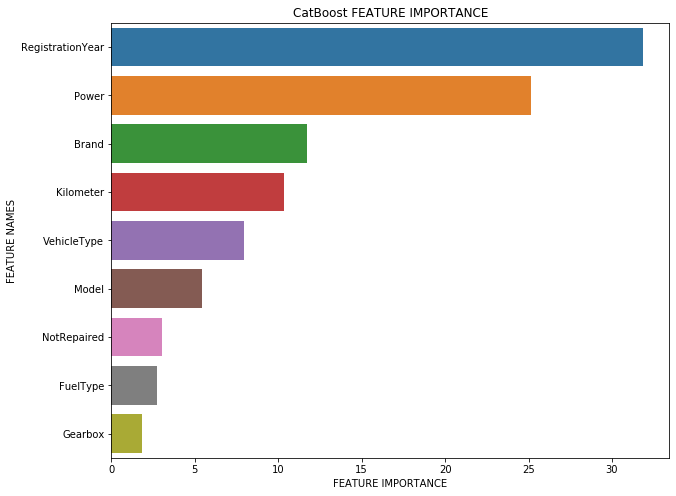

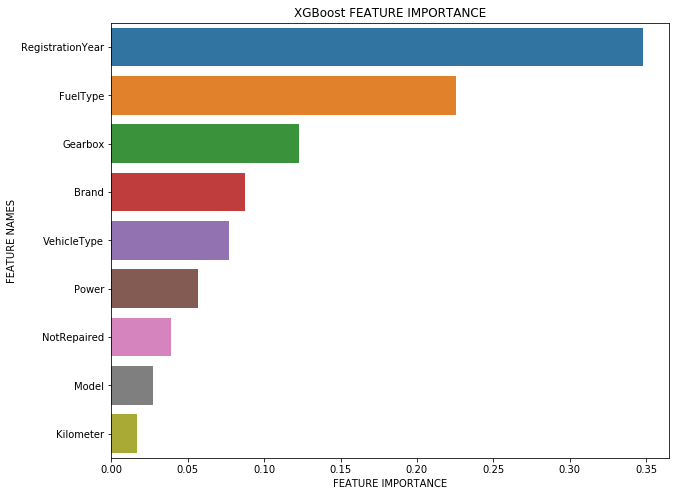

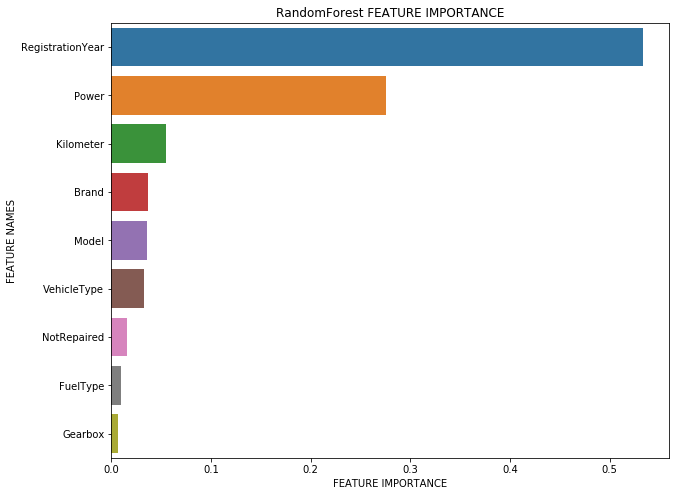

In [22]:
plot_feature_importance(model1.feature_importances_,features_train.columns,'CatBoost ')
plot_feature_importance(model3.feature_importances_,features_train.columns,'XGBoost ')
plot_feature_importance(model4.feature_importances_,features_train.columns,'RandomForest ')

<font color='blue'>Кометарий</font> Основным фактором является год регестрации<br/>

# 4. Вывод
**Можно сделать вывод, что заказчику больше всего подойдет модель CatBoost. Она самая быстрая и качественная, но если ему нужно будет ее постоянно переобучать, модель LightGBM будет наилучшим выбором. Так же есть обычная линейная регрессия. Она очень быстрая, но результат получается очень плохой. По результатам модели очень схожи если задать им одинаковые гиперпараметры.**

| Params/Model  | LinearRegression   | CatBoost | LightGBM | XGBoost | RandomForest |
| :------------- | :-------------: |:-------------: |:-------------: |:-------------: |:-------------: |
| Время Обучения  | 44 ms  | 48.2 s  | 50.2 s | 9.95 s| 44.7 s|
| Время выполнения     | 7.97 ms    |210 ms  | 1.29 s | 446 ms | 1.02 s |
| |  | | | | |
| Качество на обучающей выборке (RMSE)  | 3751.1    |1611.3  | 1717.8 | 1764.6 | 1899.1|
| Качество на тестовой выборке (RMSE)    | 3834.2 |1586  |1695.9| 1754.8|1910.2 |